# FIT5196 Assessment 1 - Task 2: Text Pre-Processing
#### Author Name: Pouria Ebrahimnezhad


Date:13/04/2019

Environment: Python 3.6.5 and Jupyter notebook
Libraries used: 
* re (for regular expression)
* nltk - natural language toolkit (tokenizer, lemmatizer, stopwords, collocations and probabilities) 
* matplotlib (for plotting)
* pylab (for plotting)


# 1. Introduction
This analysis extracts data from a PDF-based corpus containing 200 Monash University units information. I have converted the pdf file using https://pdftotext.com/ to a text file for pre-processing using this Jupyter notebook code. The original pdf file includes units synopsis and units outcomes in two seperate sections which we have extracted.

The pre-processing tasks at a high level include:
    1- Normalising units information with respect the words location in sentences according to specification request
    2- Tokenisation of units information
    3- extraction of bigrams using PMI measure
    4- re-tokenisation of units information with respect to the bigrams
    5- Removal of context independant and dependant stop words and rare words from the vocabulary
    6- Stemming of the tokens using the nltk PorterStemmer
    7- Creating a text file including the sparse count vector for each unit

# 2. Reading and scraping the file information

In [1]:
import re
from nltk import tokenize
import nltk
from itertools import chain
import matplotlib.pyplot as plt
from nltk.probability import *

reading the text file created from the original pdf and storing all lines in a list, the text file is created using https://pdftotext.com/ from the original pdf and here we clean the lines extracted from the file and also skip the first few lines which has table headers

In [2]:
with open("units_data.txt") as file:

    lines = []
    lines = file.readlines()

    for i in range(0,len(lines)):
        temp = lines[i].strip('\n')
        lines[i] = temp
        lines[i] = lines[i].replace('\x0c', '')
        lines[i] = lines[i].replace('\\n', '')
        
    for each in lines:
        if each == "":
            lines.remove(each)

    lines = lines[3:]
file.close()

Next we develop two regex to allow us to seperate each unit and it's related information in two seperate lists

In [3]:
units = []
unit_info = []
for i in range(0, len(lines)):
    flag = False
    if re.match(r"^[A-Z]{3}\d{4}$",lines[i],re.M):
        units.extend(re.findall(r"^[A-Z]{3}\d{4}$",lines[i]))
        flag = True
        if i != 0:
            unit_info.append(new_line)
        new_line = ""
    else:
        if flag == False:
            if new_line == "":
                new_line = new_line + lines[i]
            else:
                new_line = new_line + " " + lines[i]
    if i == len(lines)-1:
        unit_info.append(new_line)

now we use a dictionary to store each unit and it's related information

In [4]:
unit_dic ={}
for i in range(0, len(units)):
    unit_dic[units[i]] = unit_info[i]


# 3. Normalising units information

We develop a function which normalises the first word in each sentence to lowercase

In [5]:
def lower_func(sentence):
    words = sentence.split()
    words[0] = words[0].lower()
    new_sentence = ""
    for each in words:
        new_sentence = new_sentence + " " + each
    return(new_sentence.strip())

Now I have developed a function to split the synopsis section using the tokenize library to sentences and using the above function we convert the first words to lowercase and return synopsis as string

In [6]:
def split_sentence(synop):
    sent_list = tokenize.sent_tokenize(synop)
    sent_list = [lower_func(each) for each in sent_list]
    new_synop = ""
    for each in sent_list:
        new_synop = new_synop + " " + each
    return(new_synop.strip())

Here I convert the previous unit information from the dictionary into two lists containing outcome and synopsis and use the developed functions to normalise them and store the outcome as a tuple in a new dictionary 

In [7]:
new_unit_dic = {}
for key, value in unit_dic.items():
    bracket_sec = re.findall(r"\[(.*?)\]", value)
    outcome = re.findall(r"('.*?'|\".*?\")", bracket_sec[0])
    synopsis = re.findall(r"(.*?)\[", value)
    outcome = [lower_func(each) for each in outcome] # Here we normalise the outcome using the above function
    synopsis = split_sentence(synopsis[0])
    new_unit_dic[key] = (synopsis, outcome)


In [8]:
final_dic = {}
for key, value in new_unit_dic.items():
    syn = value[0]
    out = ""
    for each in value[1]:
        out = out + " " + each
    out.strip()
    val = syn + out
    final_dic[key] = val

we have simplified the dictionary structure joining all synopsis and outcomes as we are done with the normalisation of the text and ready to move into the next phase which is tokenising the information of the units

# 4. Tokenisation of the words in all units

I have first written a function to take a text argument and use the nltk.tokenise library and Regextokenizer to tokenise the text and return the data according to the regex provided in the specification

In [9]:
from nltk.tokenize import RegexpTokenizer

def tokenizeUnitData(data):
    tokenizer = RegexpTokenizer(r"\w+(?:[-']\w+)?")
    tokenised_data = tokenizer.tokenize(data)
    return (tokenised_data)

### 4.1. Calculating initial vocabulary

I now merge all units information and tokenise them to get the full bag of words for all units and create an initial vocabulary. I then calculate the Lexical Diversity of the corpus for future comparision

In [10]:
giant_str = ""
for key, value in final_dic.items():
    giant_str = giant_str + value
word_bag = tokenizeUnitData(giant_str)
vocab = list(set(word_bag))
LD_before = round(len(word_bag)/len(vocab),2)
print(f"there are {len(word_bag)} of words in all units and {len(vocab)} unique vocabulary")
print(f"Lexical Diversity before text wrangling: {LD_before}")

there are 32423 of words in all units and 4288 unique vocabulary
Lexical Diversity before text wrangling: 7.56


In [11]:
units_tokenised = {}
for k, v in final_dic.items():
    units_tokenised[k] = tokenizeUnitData(final_dic[k])

Here I have created a new dictionary containing the tokenised version of units information for each unit

# 5. Extracting bigrams & Collocations

Here I extract the 200 most common bigrams using the PMI measure and nltk library

In [12]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
extract = nltk.collocations.BigramCollocationFinder.from_words(word_bag)
top_200_bigrams = extract.nbest(bigram_measures.pmi, 200)

In [13]:
top_200_bigrams

[('138', 'CE'),
 ('1910-1945', 'supplemented'),
 ('AN', 'MC'),
 ('ATS1899', 'Music'),
 ('ATS2297', 'ATS3297'),
 ('Act', '2014'),
 ('Analytics', 'Lab'),
 ('Anthropocene', 'Era'),
 ('Apartheid', 'Museum'),
 ('Athenian', 'playwrights'),
 ('Augustus', 'Claudius'),
 ('Bank', 'Gaza'),
 ('Bar', "Kokhba's"),
 ('Child', 'UNCRC'),
 ('Claudius', 'Nero'),
 ('Constitution', 'Hill'),
 ('Dietary', 'Guidelines'),
 ('Dietitians', 'Association'),
 ('Division', '1RN'),
 ('GATT', 'WTO'),
 ('Gacaca', 'village'),
 ('God', 'morality'),
 ('Hispanic', 'Studies'),
 ('Julius', 'Caesar'),
 ('Korea', '1910-1945'),
 ('Management', 'Body'),
 ('Materials', 'Engineer'),
 ('Methods', 'lays'),
 ('Midwifery', 'Council'),
 ('Moot', 'Court'),
 ('Museum', 'Constitution'),
 ('NMBA', 'Registered'),
 ('NUR5002', 'Contemporary'),
 ('Nations', 'Convention'),
 ("Pearson's", 'correlation'),
 ('Phase', 'Rule'),
 ('Plato', 'Thucydides'),
 ('Praetorian', 'Guard'),
 ('Prato', 'programme'),
 ('Project', 'Management'),
 ('Regional', 'Tr

### 5.1 Re-Tokenising units information

Now since we need to include the bigrams in our vocabulary we need to re-tokenise units again with respect to the bigrams that was extracted from previous section. This is achieved using the mwetokeniser which takes care of this for us.

After this step I have generated another bag of words for all new tokens and using that I have generated a new list of collocated vocabulary, we can see that there has been a small increase in the lexical diversity of our corpus after this step

In [14]:
mwetokenizer = nltk.MWETokenizer(top_200_bigrams)
colloc_units =  dict((unit_id, mwetokenizer.tokenize(unit_tokens)) for unit_id,unit_tokens in units_tokenised.items())
all_words_colloc = list(chain.from_iterable(colloc_units.values()))
colloc_vocab = list(set(all_words_colloc))
colloc_vocab = [w for w in colloc_vocab if len(w) >= 3] # here we make sure the vocabulary includes words with more than 3 letters
LD_after_bi = round(len(all_words_colloc)/len(colloc_vocab),2)
print(f"our new collocated vocab has {len(colloc_vocab)} words")
print(f"our new Lexical Diversity after tokenisation with bigrams included: {LD_after_bi}")

our new collocated vocab has 4062 words
our new Lexical Diversity after tokenisation with bigrams included: 7.94


# 6. Removing Stop words and Rare Tokens

In this section I have used the guidelines provided in the specification to increase the lexical diversity required for the purpose of this task, the steps included here are:

* Removing the context-independent stop words
* Removing context dependent words using document frequency of 95%
* Removing Rare tokens using document frequency of 5%

### 6.1 Removing Context-independent stop words

Here I find all context-independent stop words from the provided file as per specifications and I remove them from the vocabulary.

please note that this file needs to be present when executing the code here

In [15]:
stopwords = []
with open('./stopwords_en.txt') as f:
    stopwords = f.read().splitlines()
stopwords_set = set(stopwords)
f.close()

# removing these stop words from the vocab
vocab_1 = [w for w in colloc_vocab if w not in stopwords_set]
stopped = [w for w in colloc_vocab if w in stopwords_set]
print(f"our new vocab has {len(vocab_1)} words, we have removed {len(stopped)} distinct words from the vocabulary")
print(f"This means {round(len(stopped)/len(colloc_vocab),2)*100}% of the words were removed in this step")

our new vocab has 3856 words, we have removed 206 distinct words from the vocabulary
This means 5.0% of the words were removed in this step


### 6.2 Removing Context dependant words

I first generate the document frequency for all words in our remaining vocabulary to create a visualisation of the frequency and use for the removal of frequent and rare tokens later

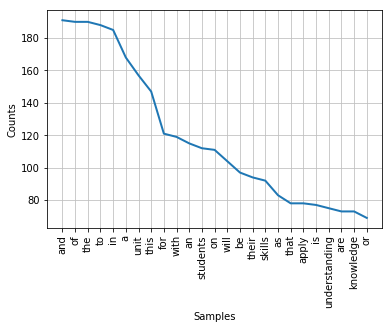

In [16]:
words_1 = list(chain.from_iterable([set(value) for value in colloc_units.values()])) 
fd_1 = FreqDist(words_1)
fd_1.plot(25)

As indicated in the specification we have to remove the words that appear in more than 95% of our units. Since I had 193 unique units in my original dictionary, this means I need to remove words that apear in more than 183 units

In [17]:
vocab_2 = [word for word in vocab_1 if fd_1[word] < 183]
frequent_words = [word for word in vocab_1 if fd_1[word] > 183]
print(f"our new vocab has {len(vocab_2)} words, we have removed {len(frequent_words)} distinct words from the vocabulary")

our new vocab has 3856 words, we have removed 0 distinct words from the vocabulary


We can see that we had no words in my corpus that meets this criteria, meaning all words are repeated with frequency of less than 95%. This step hasn't increased the lexical diversity

### 6.3 Removing Rare Tokens

I have used the code provided in the tutorial to asses the frequency of the frequencies of the words in my corpus, this allows for checking the document for rare or more frequent words, we can see that as we are looking to remove the words that appear in less than 5% of the units this corresponds to the upper part of the graph

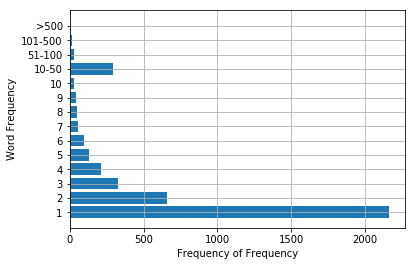

In [18]:
ffd = FreqDist(fd_1.values())
from pylab import *
y = [0]*14
for k, v in ffd.items():
     if k <= 10:
        y[k-1] = v
     elif k >10 and k <= 50:
        y[10] =  y[10] + v
     elif k >50 and k <= 100:
        y[11] =  y[11] + v
     elif k > 100 and k <= 500:
        y[12] =  y[12] + v
     else:
        y[13] =  y[13] + v
x = range(1, 15) # generate integer from 1 to 14
ytks =list(map(str, range(1, 11))) # covert a integer list to a string list
ytks.append('10-50')
ytks.append('51-100')
ytks.append('101-500')
ytks.append('>500')
barh(x,y, align='center')
yticks(x, ytks)
xlabel('Frequency of Frequency')
ylabel('Word Frequency')
grid(True)

I now find the rare tokens and remove them from the vocabulary based on document frequency of less than 5%, this means that for my corpus I need to remove the words that appear in less than 10 units

In [19]:
vocab_3 = [w for w in vocab_2 if fd_1[w]>10]
rare_words = [word for word in vocab_2 if fd_1[word] < 10]
print(f"our new vocab has {len(vocab_3)} words, we have removed {len(rare_words)} distinct words from the vocabulary")
print(f"This means {round(len(rare_words)/len(vocab_2),2)*100}% of the words were removed in this step")

our new vocab has 266 words, we have removed 3562 distinct words from the vocabulary
This means 92.0% of the words were removed in this step


I now clean all the units tokens with respect to the vocabulary I have created in the previous step and store in a new dictionary

In [20]:
units_clean_tokens = {}
for unit_id in colloc_units:
    units_clean_tokens[unit_id] = [word for word in colloc_units[unit_id] if word in vocab_3]    

# 7. Stemming and Lemmatization

Here I use the porterstemmer to stem the tokens, However through trial and error I have noticed that the porter stemmer will change all output to lowercase. I have made sure this is reflected in the code to skip any words that have upper case letters

In [21]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stem_units = {}
for key, value in units_clean_tokens.items():
    final_tokens =[]
    for i in range(len(value)):
        if value[i].islower():
            final_tokens.append(stemmer.stem(value[i]))
        else:
            final_tokens.append(value[i])
    stem_units[key] = final_tokens

# 8. Generating the final vocabulary and count vector file

Finally, I create the bag of words containing all that is left from the corpus and create the final vocabulary set, also I have claculated the final Lexical Diversity to show the improvements made post wrangling of the text

I then have created the two text files required as per the specifications with one containing the final vocabulary sorted alphabetically and the corresponding index in the vocabulary list.

Then I have generated the vector count required for each unit with the specified format.

* Note: Please note that in my corpus I had 2 units which didn't have any information for both synopsis and outcome. I have kept these in units in the output file with no information infront. I have also made sure there is no comma included after them to make sure the documents are parsable as required 

In [22]:
allwords = list(chain.from_iterable(stem_units.values()))
final_vocab = list(set(allwords))
final_vocab.sort()
LD_final = round(len(allwords)/len(final_vocab),2)

In [23]:
out_file = open("vocab.txt", 'w')
for i in range(0,len(final_vocab)):
    if i != (len(final_vocab)-1):
        out_file.write("{}:{} ".format(final_vocab[i],final_vocab.index(final_vocab[i])))
        out_file.write('\n')
    else:
        out_file.write("{}:{} ".format(final_vocab[i],final_vocab.index(final_vocab[i])))
out_file.close()

In [24]:
out_file = open("countVec.txt", 'w')
for k,v in stem_units.items():
    if v != []:
        out_file.write("{},".format(k))
        for i in range(0, len(v)):
            if i != (len(v) - 1):
                out_file.write("{}:{},".format(final_vocab.index(v[i]),v.count(v[i])))
            else:
                out_file.write("{}:{}".format(final_vocab.index(v[i]),v.count(v[i])))
        out_file.write('\n')
    else:
        out_file.write("{}".format(k))
        out_file.write('\n')
    #stats_dic[k] = sparse
out_file.close()

# 9. Summary

The wrangling steps shows how a text which had below statistics, was reduced with respect to the main features which could be used for further processing such as topic modelling, search and other information extraction.

In [25]:
# Text statistics before Wrangling
print(f"Total number of words: {len(word_bag)}")
print(f"Total number of vocabs: {len(vocab)}")
print(f"Lexical Diversity before text wrangling: {LD_before}")

Total number of words: 32423
Total number of vocabs: 4288
Lexical Diversity before text wrangling: 7.56


In [26]:
# Text statistics after Wrangling
print(f"Total number of words: {len(allwords)}")
print(f"Total number of vocabs: {len(final_vocab)}")
print(f"Lexical Diversity before text wrangling: {LD_final}")

Total number of words: 9188
Total number of vocabs: 211
Lexical Diversity before text wrangling: 43.55
